In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import ssl
import certifi
import io
from stockfish import Stockfish
import datetime
import matplotlib.pyplot as plt
import chess.pgn
import chess
import chess.engine

## Import chess.com data based on username and desired years, then create a database called my_games.

In [2]:

ssl_cert_file = certifi.where()
ssl_context = ssl.SSLContext(ssl.PROTOCOL_TLS_CLIENT)
ssl_context.load_verify_locations(ssl_cert_file)

my_games = pd.DataFrame(columns = ['datetime', 'my color', 'time format', 'time control', 'my rating', 'opponent rating', 'result', 'opponent result', 'starting position', 'moves']) #sets up the data frame to store games

year_start = 2020
year_end = 2023
months = range(1,13)
for year in range(year_start, year_end + 1):
    for month in months:
        try: 
            url = f'https://api.chess.com/pub/player/jnbradley828/games/{str(year)}/{month:02}'
            response = urlopen(url, context=ssl_context)
            data = response.read().decode('utf-8', 'replace')
            data = pd.read_json(io.StringIO(data))
        except:
            print(month, year, 'could not be parsed because of future date')

        for game in data['games']:
            
            if game['rated'] == True and game['rules'] == 'chess':
                my_username = 'jnbradley828'
                my_color = ''
                opp_color = ''
                if game['white']['username'] == my_username:
                    my_color = 'white'
                    opp_color = 'black'
                elif game['black']['username'] == my_username:
                    my_color = 'black'
                    opp_color = 'white'
                    
                try:
                    pgn=game['pgn']
                    pgn_read = chess.pgn.read_game(io.StringIO(pgn))
                    try:
                        start_pos = pgn_read.headers['FEN']
                    except:
                        start_pos = None
                    moves = [move.uci() for move in pgn_read.mainline_moves()]
                except:
                    moves = None
    
                new_row = pd.DataFrame({
                    'datetime': [datetime.datetime.fromtimestamp(game['end_time'])], #important to note that this outputs the time in your system's timezone.
                    'my color': [my_color],
                    'time format': [game['time_class']],
                    'time control': [game['time_control']],
                    'my rating': [game[my_color]['rating']],
                    'opponent rating': [game[opp_color]['rating']],
                    'result': [game[my_color]['result']],
                    'opponent result': [game[opp_color]['result']],
                    'starting position': [start_pos],
                    'moves': [moves]
                          })
                my_games = pd.concat([my_games, new_row], ignore_index=True)

my_games.set_index('datetime', inplace=True)

my_games.drop(my_games[my_games['moves'].apply(len) < 3].index, inplace=True)

print(my_games.head())
print(len(my_games))

/var/folders/01/mldp0g2d0h57s08vdtwnz8zh0000gn/T/ipykernel_5878/3607826332.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  my_games = pd.concat([my_games, new_row], ignore_index=True)


                    my color time format time control my rating  \
datetime                                                          
2020-02-24 17:10:20    black       daily      1/86400       900   
2020-02-26 21:15:04    white       daily      1/86400      1005   
2020-02-28 20:44:09    black       daily      1/86400       979   
2020-03-01 12:43:54    black       daily      1/86400      1007   
2020-03-01 17:56:33    black       blitz        180+2       835   

                    opponent rating      result opponent result  \
datetime                                                          
2020-02-24 17:10:20            1277  checkmated             win   
2020-02-26 21:15:04            1249         win      checkmated   
2020-02-28 20:44:09            1231    resigned             win   
2020-03-01 12:43:54             777         win      checkmated   
2020-03-01 17:56:33             834         win      checkmated   

                    starting position  \
datetime           

## From my_games, create a new data frame called time_vs_win that categorizes each game into what hour of day it was played. Include only time format and result.

In [3]:
time_vs_win = pd.DataFrame(columns = ['hour', 'time of day', 'time format', 'result'])
for game in my_games.iloc():
    if game['time format'] == 'daily':
        continue         # We need to exclude daily/correspondence games, because they span multiple days and thus could skew the data based on the time the game ended.
    hour = int(game.name.strftime("%H"))
    if hour < 6 and hour >= 0:
        new_row = pd.DataFrame({'hour': [hour], 'time of day': 'night', 'time format': game['time format'], 'result': game['result']})
    elif hour < 12 and hour >= 6:
        new_row = pd.DataFrame({'hour': [hour], 'time of day': 'morning', 'time format': game['time format'], 'result': game['result']})
    elif hour < 18 and hour >= 12:
        new_row = pd.DataFrame({'hour': [hour], 'time of day': 'afternoon', 'time format': game['time format'], 'result': game['result']})
    elif hour > 18:
        new_row = pd.DataFrame({'hour': [hour], 'time of day': 'evening', 'time format': game['time format'], 'result': game['result']})
    time_vs_win = pd.concat([time_vs_win, new_row], ignore_index=True)

print(time_vs_win.head())
print(time_vs_win['result'].unique())
print(time_vs_win['hour'].unique())

  hour time of day time format result
0   17   afternoon       blitz    win
1   17   afternoon       blitz    win
2   17   afternoon       blitz    win
3   19     evening       rapid    win
4   20     evening       rapid    win
['win' 'resigned' 'checkmated' 'timeout' 'abandoned' 'agreed' 'repetition'
 'timevsinsufficient' 'stalemate' 'insufficient' '50move']
[17 19 20 21 13 14 15 12 22 16 10 11 23 0 8 9 1 7]


## Convert detailed results in time_vs_win (such as 'resigned', 'agreement', etc. ) into numeric chess results (1 = win, 0.5 = draw, 0 = loss).

In [4]:
win = ['win']
draw = ['agreed', 'repetition', 'timevsinsufficient', 'stalemate', 'insufficient', '50move']
loss = ['checkmated', 'resigned', 'timeout', 'abandoned']

def determine_value(row):
    if row['result'] in win:
        return 1
    elif row['result'] in draw:
        return 0.5
    elif row['result'] in loss:
        return 0

time_vs_win['numeric result'] = time_vs_win.apply(determine_value, axis = 1)

## Exclude any hours during the day which contain less than 50 games. Then create a line graph of the probability of winning in all time controls based on hour of day. Then separate by time control, exclude hours with less than 30 games, and add to the plot.

Figure(1000x500)


/var/folders/01/mldp0g2d0h57s08vdtwnz8zh0000gn/T/ipykernel_5878/2934957850.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([map_hours(x) for x in xticks_def])


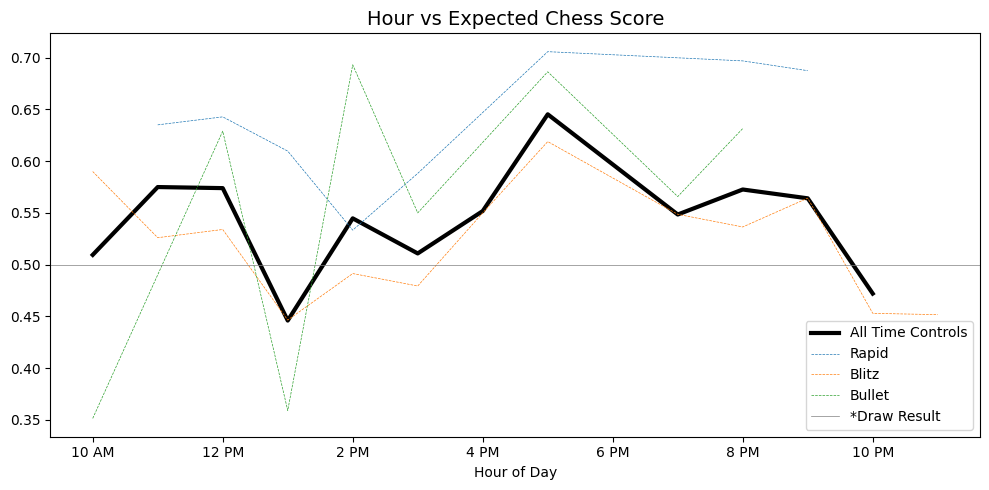

In [5]:
hours_to_exclude = [] #Exclude hours with less than 50 games.
for inti in range(0,25):
    try:
        if time_vs_win.groupby('hour').count()['time of day'][inti] < 50:
            hours_to_exclude.append(inti)
    except:
        continue

_a = time_vs_win.groupby('hour').mean('numeric result').reset_index()
hour_vs_numeric_result = _a[~_a['hour'].isin(hours_to_exclude)]

ax = hour_vs_numeric_result.plot(x = 'hour',
                            y = 'numeric result', 
                            kind = 'line', 
                            figsize = (10,5), 
                            xlabel = 'Hour of Day', 
                            label = 'All Time Controls',
                            legend = False,
                            linewidth = 3,
                            color = 'black'
                                )
ax.set_title('Hour vs Expected Chess Score', fontsize = 14)

## Plot the individual time formats.

_b = time_vs_win.groupby(['time format', 'hour'])['numeric result'].agg(mean = 'mean', count = 'count')

time_vs_win_Rapid = _b.loc['rapid'].reset_index()
time_vs_win_Blitz = _b.loc['blitz'].reset_index()
time_vs_win_Bullet = _b.loc['bullet'].reset_index()

min_count = 30
time_vs_win_Rapid = time_vs_win_Rapid[time_vs_win_Rapid['count'] >= min_count]
time_vs_win_Blitz = time_vs_win_Blitz[time_vs_win_Blitz['count'] >= min_count]
time_vs_win_Bullet = time_vs_win_Bullet[time_vs_win_Bullet['count'] >= min_count]

ax.plot(time_vs_win_Rapid['hour'], time_vs_win_Rapid['mean'], label = 'Rapid', linestyle = '--', linewidth = .5)
ax.plot(time_vs_win_Blitz['hour'], time_vs_win_Blitz['mean'], label = 'Blitz', linestyle = '--', linewidth = .5)
ax.plot(time_vs_win_Bullet['hour'], time_vs_win_Bullet['mean'], label = 'Bullet', linestyle = '--', linewidth = .5)

ax.axhline(y=0.5, color='gray', linestyle='-', label='*Draw Result', linewidth = 0.5)
ax.legend()

#Change x ticks to standard time labels.
def map_hours(x):
    x_int = x.item()
    hour_mapping = {
        0: '12 AM',
        1: '1 AM',
        2: '2 AM',
        3: '3 AM',
        4: '4 AM',
        5: '5 AM',
        6: '6 AM',
        7: '7 AM',
        8: '8 AM',
        9: '9 AM',
        10: '10 AM',
        11: '11 AM',
        12: '12 PM',
        13: '1 PM',
        14: '2 PM',
        15: '3 PM',
        16: '4 PM',
        17: '5 PM',
        18: '6 PM',
        19: '7 PM',
        20: '8 PM',
        21: '9 PM',
        22: '10 PM',
        23: '11 PM',
        24: ''
    }
    return hour_mapping[x_int]
    
xticks_def = ax.get_xticks()
ax.set_xticklabels([map_hours(x) for x in xticks_def])

fig = ax.get_figure()
plt.tight_layout()
fig.savefig('Hours vs Expected Result.png')
print(fig)

In [6]:
my_games = my_games.reset_index()
my_games['games in last week'] = None

## Add numeric results and games in last week to my_games (this could be more efficient if I added numeric results earlier, as the code was copied from above.

In [7]:
for index, game in my_games.iterrows():
    time_from_game_df = game['datetime'] - my_games['datetime']
    count_within_week = len(time_from_game_df[(time_from_game_df <= datetime.timedelta(days=7)) & (time_from_game_df > datetime.timedelta(days=0))])
    my_games.loc[index, 'games in last week'] = count_within_week

win = ['win']
draw = ['agreed', 'repetition', 'timevsinsufficient', 'stalemate', 'insufficient', '50move']
loss = ['checkmated', 'resigned', 'timeout', 'abandoned']

def determine_value(row):
    if row['result'] in win:
        return 1
    elif row['result'] in draw:
        return 0.5
    elif row['result'] in loss:
        return 0

my_games['numeric result'] = my_games.apply(determine_value, axis = 1)


## Filter out weekly game amounts with less than 30 games, then graph. We might categorize weekly games instead.

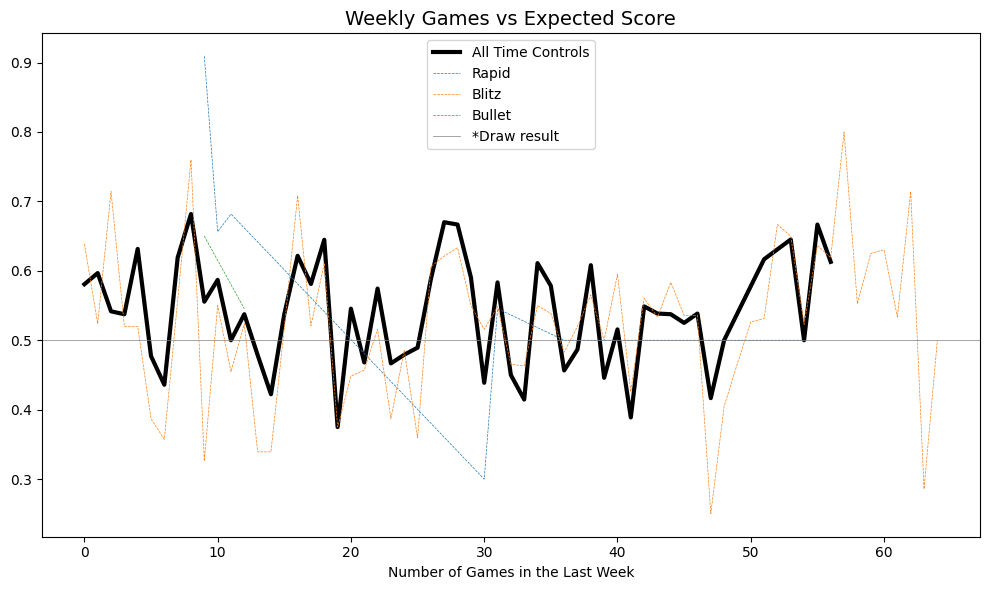

In [8]:
weekly_games_vs_result = my_games.groupby('games in last week')['numeric result'].agg(mean = 'mean', count = 'count')
weekly_games_vs_result = weekly_games_vs_result[weekly_games_vs_result['count'] >= 30]
weekly_games_vs_result = weekly_games_vs_result.reset_index()

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(weekly_games_vs_result['games in last week'], weekly_games_vs_result['mean'], label = 'All Time Controls', linewidth = 3, color = 'black')

plt.title('Weekly Games vs Expected Score', fontsize = 14)
plt.xlabel('Number of Games in the Last Week')

weekly_games_by_format = my_games.groupby(['time format', 'games in last week'])['numeric result'].agg(mean = 'mean', count = 'count').reset_index()
weekly_games_Rapid = weekly_games_by_format[weekly_games_by_format['time format'] == 'rapid']
weekly_games_Rapid = weekly_games_Rapid[weekly_games_Rapid['count'] >= 10]

weekly_games_Blitz = weekly_games_by_format[weekly_games_by_format['time format'] == 'blitz']
weekly_games_Blitz = weekly_games_Blitz[weekly_games_Blitz['count'] >= 10]

weekly_games_Bullet = weekly_games_by_format[weekly_games_by_format['time format'] == 'bullet']
weekly_games_Bullet = weekly_games_Bullet[weekly_games_Bullet['count'] >= 10]

ax.plot(weekly_games_Rapid['games in last week'], weekly_games_Rapid['mean'], label = 'Rapid', linewidth = 0.5, linestyle = '--')
ax.plot(weekly_games_Blitz['games in last week'], weekly_games_Blitz['mean'], label = 'Blitz', linewidth = 0.5, linestyle = '--')
ax.plot(weekly_games_Bullet['games in last week'], weekly_games_Bullet['mean'], label = 'Bullet', linewidth = 0.5, linestyle = '--')

ax.axhline(y=0.5, color='gray', linestyle='-', label='*Draw result', linewidth = 0.5)
ax.legend()
plt.tight_layout()

fig.savefig('Weekly Games vs Expected Result.png')

## ^^ Interestingly, it appears there is no correlation at all. Another interesting one is performance by rating difference.

/var/folders/01/mldp0g2d0h57s08vdtwnz8zh0000gn/T/ipykernel_5878/1334295466.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_games_ratingfil['rating bucket'] =( ( (my_games_ratingfil['rating difference'] - null_bucket_min) // bucket_size ) * bucket_size ) + null_bucket_min


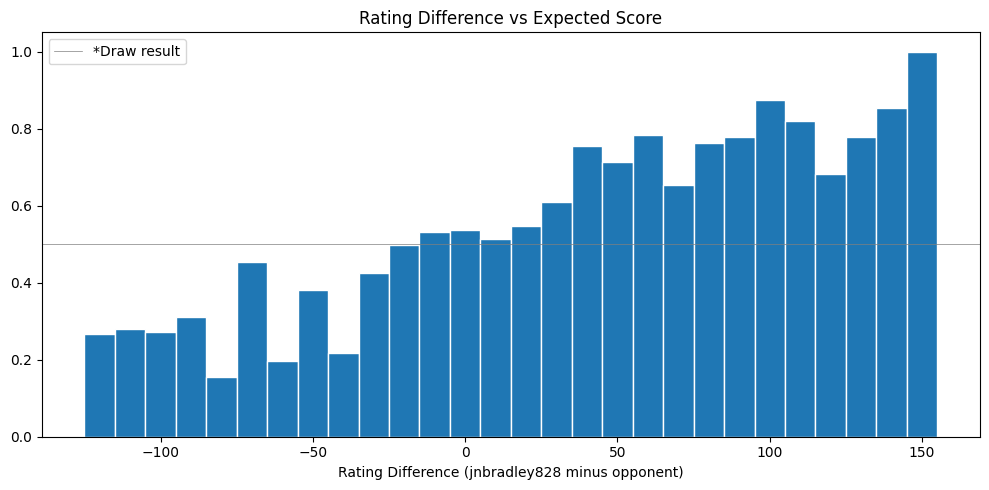

In [9]:
my_games['rating difference'] = my_games['my rating'] - my_games['opponent rating']
my_games_ratingfil = my_games[  (my_games['rating difference'] > my_games['rating difference'].quantile(.025)) & (my_games['rating difference'] < my_games['rating difference'].quantile(.975))  ]

##Let's group rating differences into buckets and analyze.
bucket_size = 10
null_bucket_min = -5

my_games_ratingfil['rating bucket'] =( ( (my_games_ratingfil['rating difference'] - null_bucket_min) // bucket_size ) * bucket_size ) + null_bucket_min
my_games_rating_data = my_games_ratingfil.groupby('rating bucket')['numeric result'].agg(count = 'count', mean = 'mean').reset_index()

fig, ax = plt.subplots(figsize = (10,5))
ax.bar(my_games_rating_data['rating bucket'], my_games_rating_data['mean'], align = 'edge', width = 10, edgecolor = 'white')
ax.set_title('Rating Difference vs Expected Score')
ax.set_xlabel(f'Rating Difference ({my_username} minus opponent)')
ax.axhline(y=0.5, color='gray', linestyle='-', label='*Draw result', linewidth = 0.5, zorder = 2)

ax.legend()
plt.tight_layout()

fig.savefig('Rating Difference vs Expected Score.png')

## Now let's see if game length (number of moves) affects my winning percentage.

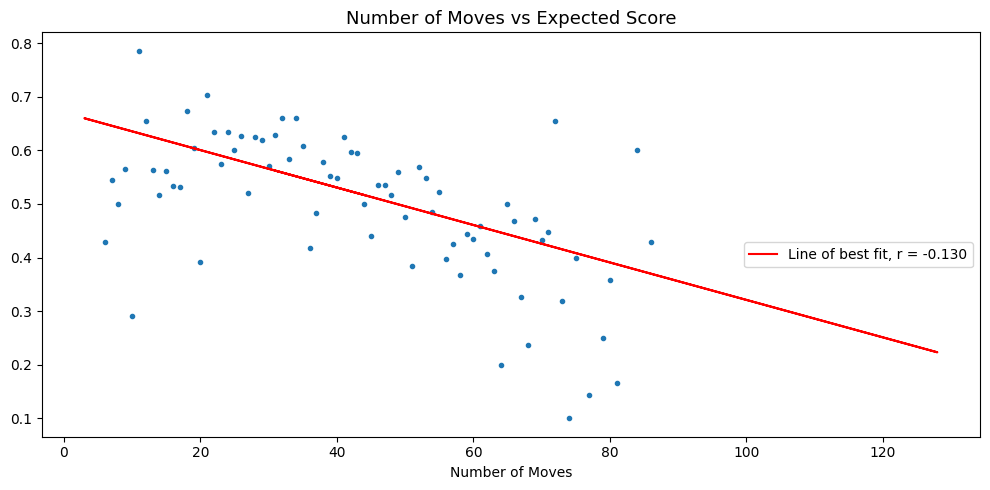

In [10]:
import math

fig, ax = plt.subplots(figsize = (10,5))

my_games['number of moves'] = my_games['moves'].apply(lambda x: math.ceil(len(x) / 2))
moves_vs_score = my_games.groupby('number of moves')['numeric result'].agg(mean = 'mean', count = 'count').reset_index()
moves_vs_score = moves_vs_score[  (moves_vs_score['number of moves'] > moves_vs_score['number of moves'].quantile(.025)) & (moves_vs_score['number of moves'] < moves_vs_score['number of moves'].quantile(.975))  ] #Clean out the outliers.
moves_vs_score = moves_vs_score[  moves_vs_score['count'] >= 5 ]

ax.scatter(moves_vs_score['number of moves'], moves_vs_score['mean'], marker = '.')
corr = my_games['number of moves'].corr(my_games['numeric result'])
slope, intercept = np.polyfit(my_games['number of moves'], my_games['numeric result'], 1)
ax.plot(my_games['number of moves'], slope * my_games['number of moves'] + intercept, color = 'red', label = f'Line of best fit, r = {corr:.3f}')

ax.legend(loc = 'right', bbox_to_anchor = (1, 0.45))
ax.set_title('Number of Moves vs Expected Score', fontsize = 13)
ax.set_xlabel('Number of Moves')
plt.tight_layout()

fig.savefig('Number of Moves vs Expected Score.png')

## ^^ Strange because I thought the endgame was the strongest point of my game. However, it may also be because I don't like to resign when I'm losing, but my opponents do. So games of mine that end early are stacked with opponent resignations while games of mine that end late are stacked with losing games where I refuse to resign.

/var/folders/01/mldp0g2d0h57s08vdtwnz8zh0000gn/T/ipykernel_5878/257035463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_games['first move'] = my_games['moves'].apply(lambda x: x[0] if x else None)
/var/folders/01/mldp0g2d0h57s08vdtwnz8zh0000gn/T/ipykernel_5878/257035463.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_games['first move'] = my_games['moves'].apply(lambda x: x[0] if x else None)


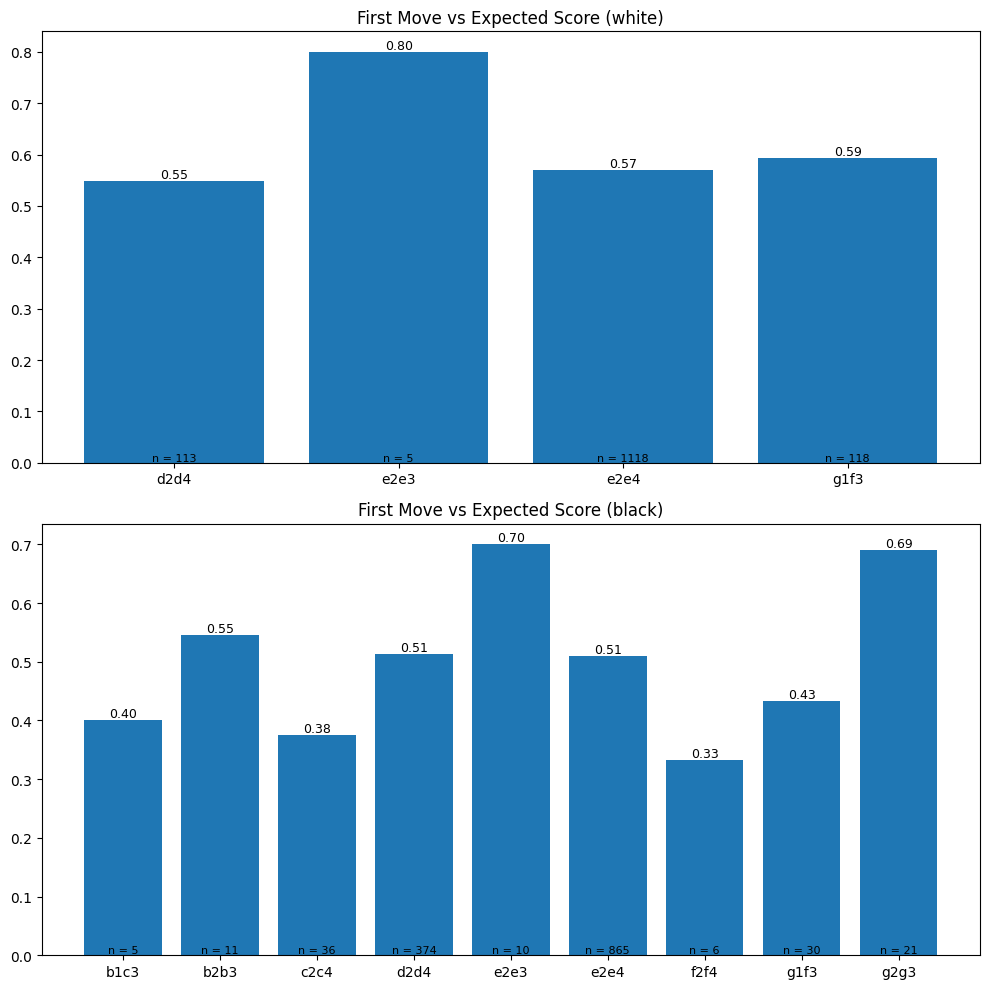

In [11]:
# White color first
white_games = my_games[my_games['my color'] == 'white']
white_games['first move'] = my_games['moves'].apply(lambda x: x[0] if x else None)
white_first_move = white_games.groupby('first move')['numeric result'].agg(mean='mean', count='count').reset_index()
white_first_move = white_first_move[white_first_move['count'] >= 5]

# Black color
black_games = my_games[my_games['my color'] == 'black']
black_games['first move'] = my_games['moves'].apply(lambda x: x[0] if x else None)
black_first_move = black_games.groupby('first move')['numeric result'].agg(mean='mean', count='count').reset_index()
black_first_move = black_first_move[black_first_move['count'] >= 5]

# Combine figures vertically
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# White figure
bars1 = ax1.bar(white_first_move['first move'], white_first_move['mean'])

xtick_labels1 = [label.get_text() for label in ax1.get_xticklabels()]

for bar, xtick_label in zip(bars1, xtick_labels1):
    count_value = white_first_move.loc[white_first_move['first move'] == xtick_label, 'count'].values[0]
    ax1.text(bar.get_x() + bar.get_width() / 2, 0, f'n = {count_value}', ha='center', va='bottom', fontsize=8)
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval if yval > 0.05 else 0.05, f'{yval:.2f}', ha='center',
             va='bottom', fontsize=9)

ax1.set_title('First Move vs Expected Score (white)')

# Black figure
bars2 = ax2.bar(black_first_move['first move'], black_first_move['mean'])

xtick_labels2 = [label.get_text() for label in ax2.get_xticklabels()]

for bar, xtick_label in zip(bars2, xtick_labels2):
    count_value = black_first_move.loc[black_first_move['first move'] == xtick_label, 'count'].values[0]
    ax2.text(bar.get_x() + bar.get_width() / 2, 0, f'n = {count_value}', ha='center', va='bottom', fontsize=8)
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval if yval > 0.05 else 0.05, f'{yval:.2f}', ha='center',
             va='bottom', fontsize=9)

ax2.set_title('First Move vs Expected Score (black)')

# Adjust layout
plt.tight_layout()

fig.savefig('First Move vs Expected Score.png')

In [12]:
#initialize Stockfish engine.
engine = chess.engine.SimpleEngine.popen_uci('stockfish')

#make a function that analyzes a single move.
def analyze_move(board, move, time_limit, color_pov):
    board.push(chess.Move.from_uci(move))
    result = engine.analyse(board, chess.engine.Limit(time = time_limit))
    if color_pov == 'white':
        cp_result = result['score'].white().score(mate_score=1000)
    elif color_pov == 'black':
        cp_result = result['score'].black().score(mate_score=1000)
    if cp_result > 1000:
        cp_result = 1000
    return cp_result

#make a function that analyzes a whole game.
def analyze_game(starting_board: str, moves: list, time_limit: int, color_pov: 'black' or 'white'):
    if starting_board is not None:
        board = chess.Board(fen = starting_board)
    else:
        board = chess.Board()
    if color_pov == 'white':
        moves_eval = [engine.analyse(board, chess.engine.Limit(time = time_limit))['score'].white().score(mate_score=10000)]
    elif color_pov == 'black':
        moves_eval = [engine.analyse(board, chess.engine.Limit(time = time_limit))['score'].black().score(mate_score=10000)]
    
    for move in moves:
        moves_eval.append(analyze_move(board, move, time_limit, color_pov))
    return moves_eval

#make a function that finds the average centipawn loss per move.
def cp_losses(starting_board, moves: list, time_limit: int, color_pov: 'black' or 'white'):
    evals = analyze_game(starting_board, moves, time_limit, color_pov)
    
    cp_losses = []
    
    if (color_pov == 'white' and starting_board is None) or (starting_board is not None and color_pov == 'black'):
        for index, value in enumerate(evals):
            #index 0 is the starting position. Thus, odd numbered evals take place after white's move.
            if index % 2 == 1:
                this_cp_loss = evals[index - 1] - value
                if this_cp_loss < 0:
                    this_cp_loss = 0
                cp_losses.append(this_cp_loss)
    
    elif (color_pov == 'black' and starting_board is None) or (starting_board is not None and color_pov == 'white'):
        for index, value in enumerate(evals):
            #index 0 is the starting position. Thus, even numbered evals (excluding index=0) take black after black's move.
            if index % 2 == 0 and index != 0:
                this_cp_loss = evals[index - 1] - value
                if this_cp_loss < 0:
                    this_cp_loss = 0
                cp_losses.append(this_cp_loss)

    return cp_losses

In [13]:
# now to try to do this for all of our chess games... 
my_games['centipawn losses'] = None
my_games['average centipawn loss'] = None

def mean(x: list):
    return (sum(x) / len(x))

for index, game in my_games.iterrows():
    #try:
    my_games.at[index, 'centipawn losses'] = cp_losses(starting_board = game['starting position'], moves = game['moves'], time_limit = 0, color_pov = game['my color'])
    #time_limit = 0 so that engine runs at fastest possible speed, if you want more accuracy, try increasing to 0.2 seconds or so. Any more and the code may take hours to run.
    my_games.at[index, 'average centipawn loss'] = mean(my_games.loc[index, 'centipawn losses'])

    if index % 200 == 0:
        print(f'{(index/len(my_games) * 100):.1f}% complete')
    #except:
        #print(index, game['moves'])


0.0% complete
7.3% complete
14.6% complete
22.0% complete
29.3% complete
36.6% complete
43.9% complete
51.2% complete
58.5% complete
65.9% complete
73.2% complete
80.5% complete
87.8% complete
95.1% complete


{'blitz': 60.86643428962312, 'bullet': 77.6396056674532, 'daily': 37.14243608145985, 'rapid': 50.21038459121969}


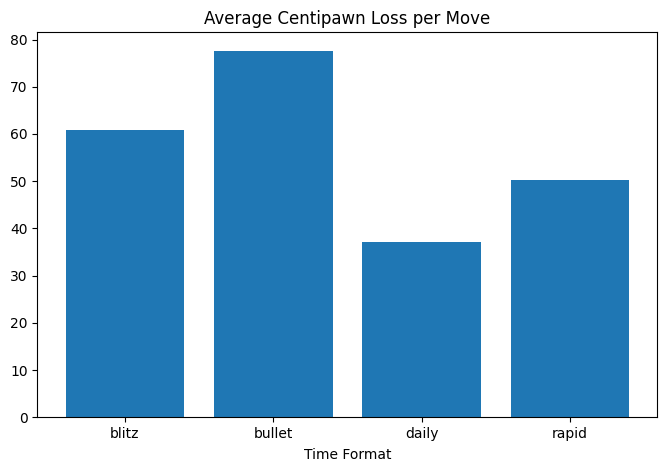

In [14]:
avg_cp_loss_vs_format = my_games.groupby('time format')['average centipawn loss'].mean()
avg_cp_format = {key: value for key, value in avg_cp_loss_vs_format.items()}
print(avg_cp_format)
#group avg cp loss by time format (blitz, rapid, etc. and put it in a dictionary.)

#graph it
fig, ax = plt.subplots(figsize = (8,5))
bar = ax.bar(list(avg_cp_format.keys()), list(avg_cp_format.values()))
ax.set_title('Average Centipawn Loss per Move')
ax.set_xlabel('Time Format', labelpad = 5)

fig.savefig('Average Centipawn Loss per Move.png')

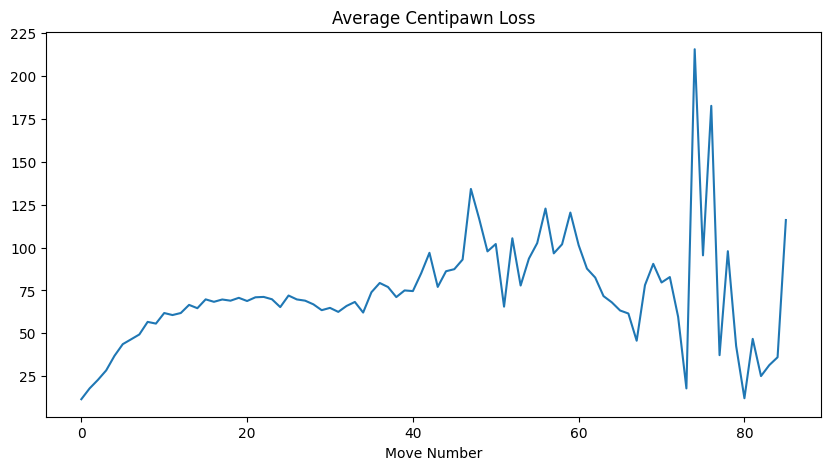

In [15]:
#now to find centipawn loss per move number.

move_vs_cp = {}
for index, game in my_games['centipawn losses'].items():
    for index2, move in enumerate(game):
        if index2 not in move_vs_cp:
            move_vs_cp[index2] = [move]
        elif index2 in move_vs_cp:
            move_vs_cp[index2].append(move)

move_vs_cp_avg = {}
for move_num, cp_loss in move_vs_cp.items():
    if len(cp_loss) > 30:
        move_vs_cp_avg[move_num] = mean(cp_loss)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(list(move_vs_cp_avg.keys()), list(move_vs_cp_avg.values()))
ax.set_title('Average Centipawn Loss')
ax.set_xlabel('Move Number')

fig.savefig('Average Centipawn Loss vs. Move Number.png')

In [17]:
move_vs_cp_rapid = {}
for index, game in my_games['centipawn losses'].items():
    if game['time format'] == blitz:
        for index2, move in enumerate(game):
            if index2 not in move_vs_cp:
                move_vs_cp[index2] = [move]
            elif index2 in move_vs_cp:
                move_vs_cp[index2].append(move)

             datetime my color time format time control my rating  \
0 2020-02-24 17:10:20    black       daily      1/86400       900   
1 2020-02-26 21:15:04    white       daily      1/86400      1005   
2 2020-02-28 20:44:09    black       daily      1/86400       979   
3 2020-03-01 12:43:54    black       daily      1/86400      1007   
4 2020-03-01 17:56:33    black       blitz        180+2       835   

  opponent rating      result opponent result starting position  \
0            1277  checkmated             win              None   
1            1249         win      checkmated              None   
2            1231    resigned             win              None   
3             777         win      checkmated              None   
4             834         win      checkmated              None   

                                               moves games in last week  \
0  [e2e4, e7e5, g1f3, d7d6, f1d3, b8c6, c2c3, g8f...                  0   
1  [d2d4, d7d5, g1f3, b8c6, b1c3